# Data Challenge Report
 
Hiran N MM21B030


In order to tackle this multi-label classification problem, two main approaches were explored. Each approach utilized different model types and techniques to optimize performance, with a focus on maximizing the micro F2-score.

**Approach 1: Traditional Machine Learning Models**

The first approach involved breaking down the multi-label classification task into multiple binary classification problems. By treating each ICD10 code as a separate binary label, the following models were tested:

Logistic Regression: A baseline model was built using logistic regression, given its ability to handle binary classification tasks efficiently and its interpretability.

Decision Trees: Decision Trees were also considered; however, due to computational constraints and slower training times, this model was later abandoned in favor of faster alternatives like logistic regression.
To further improve performance, several data reduction techniques were applied:

Principal Component Analysis (PCA): PCA was used to reduce feature dimensionality while retaining 95% of the variance.
Low-Frequency Label Pruning: Labels with occurrences below a certain threshold were removed from the dataset, helping to reduce noise and improve focus on labels with sufficient data representation.
Despite these optimizations, the micro F2-score on the leaderboard plateaued at 0.3, suggesting the need for a more powerful model.

**Approach 2: Deep Learning Models**

Given the limited success of traditional models, a second approach using deep learning was employed. This approach included various neural network architectures to handle the complex, multi-label nature of the data:

Convolutional Neural Networks (CNNs): While CNNs are typically used for image data, they were tested here to capture potential spatial relationships in the embeddings. However, they did not yield significant improvements for this dataset.
Recurrent Neural Networks (RNNs): RNNs were also explored to model sequential dependencies, though they proved ineffective for this static embedding data.
Artificial Neural Networks (ANNs): The final and most successful model was an Artificial Neural Network. ANNs naturally suit multi-label classification by allowing each neuron in the output layer to represent the probability of a corresponding label’s presence. The final ANN model achieved a significant improvement, reaching a micro F2-score of 0.461, outperforming all previous models.





Installing necessary libraries...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import joblib
import random
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import numpy as np



# Loading Data

Both the dataset were loaded together...total number of datapoints and labels are printed

In [3]:
X_full = np.load(r"C:\Users\hiran\Desktop\SEM7\DAL\Final_Challenge\embeddings_1.npy")
X_full_2 = np.load(r"C:\Users\hiran\Desktop\SEM7\DAL\Final_Challenge\embeddings_2.npy")
X_full = np.vstack((X_full, X_full_2))
print(X_full.shape)

with open(r'C:\Users\hiran\Desktop\SEM7\DAL\Final_Challenge\icd_codes_1.txt', 'r') as file:
    lines = file.readlines()

# Convert the list of lines to a NumPy array
y_full = np.array([line.strip() for line in lines])
y_full_processed = [labels.split(';') for labels in y_full]

with open(r'C:\Users\hiran\Desktop\SEM7\DAL\Final_Challenge\icd_codes_2.txt', 'r') as file:
    lines = file.readlines()

# Convert the list of lines to a NumPy array
y_full_2 = np.array([line.strip() for line in lines])
y_full_processed_2 = [labels.split(';') for labels in y_full_2]

y_full_processed.extend(y_full_processed_2)

# Print the length of the combined list
print(len(y_full_processed))

(198982, 1024)
198982


# EDA and Data Engineering

In this section, you can outline both your y (target) and X (feature) transformations, explaining each step.

**Target Transformation (y):**

MultiLabelBinarizer for Encoding: The target variable, y, was multi-label encoded using MultiLabelBinarizer(), which enabled the model to handle multiple ICD10 codes per data point.
Low-Frequency Pruning: Since our metric of interest is the micro-averaged F2 score, labels with extremely low occurrences (less than 0.1% of the dataset) were removed. This decision helped in reducing noise and focusing on labels with sufficient data representation. Specifically, labels that occurred in less than 1% of the dataset were filtered out. Approximately 1000 labels were removed this way.

**Feature Transformation (X):**

Variance Check: To reduce dimensionality and noise, we checked for features with low variance. However, no features met the criteria for exclusion.
Principal Component Analysis (PCA): Applied PCA with n_components=0.95 to retain 95% of the variance. This transformation also helped reduce memory usage by reducing funmber of features from 1024 to ~460. Also data was converted to np.float32 for further space redn

Number of data points: 198982
Number of unique labels: 1400
Number of data points with no labels: 0


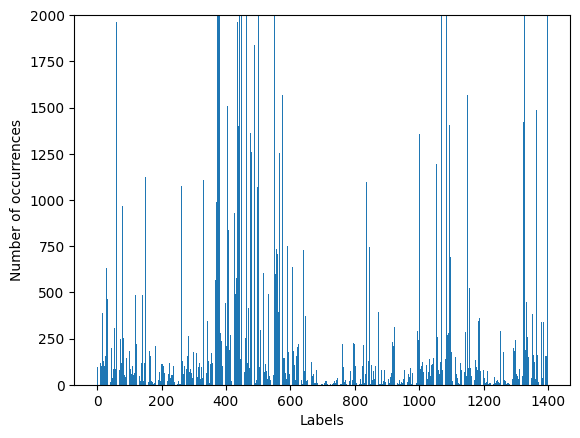

These many codes occur in less than 1 percent of people: 0.7214285714285714
New number of labels:
 390


In [4]:
# Transform labels into binary format

mlb = MultiLabelBinarizer()
mlb.fit(y_full_processed)
y_full_binary = mlb.transform(y_full_processed)

print("Number of data points:", y_full_binary.shape[0])
print("Number of unique labels:", y_full_binary.shape[1])
print("Number of data points with no labels:", y_full_binary[y_full_binary.sum(axis=1) == 0].shape[0])

# Plotting the histogram of label occurrences
labels_count = y_full_binary.sum(axis=0)
plt.bar(list(range(y_full_binary.shape[1])), labels_count)
plt.xlabel("Labels")
plt.ylabel("Number of occurrences")
plt.ylim(top=2000)
plt.show()

# Weakly sampled labels
weak_list = [i for i in range(len(labels_count)) if labels_count[i] < 0.001 * y_full_binary.shape[0]]

print("These many codes occur in less than 1 percent of people:", len(weak_list)/len(labels_count))


# Remove weak labels from y_full_processed
y_full_filtered = [[label for label in labels if label not in mlb.classes_[weak_list]] for labels in y_full_processed]

# Initialize and fit a new MultiLabelBinarizer on the filtered data
mlb_new = MultiLabelBinarizer()
mlb_new.fit(y_full_filtered)
y = mlb_new.transform(y_full_filtered)

# Output the new binary representation and classes
print("New number of labels:\n",  y.shape[1])

# Max accuracy that can be reached
# print(fbeta_score(y_full_binary, mlb.transform(y_full_filtered), beta=2, average='micro'))

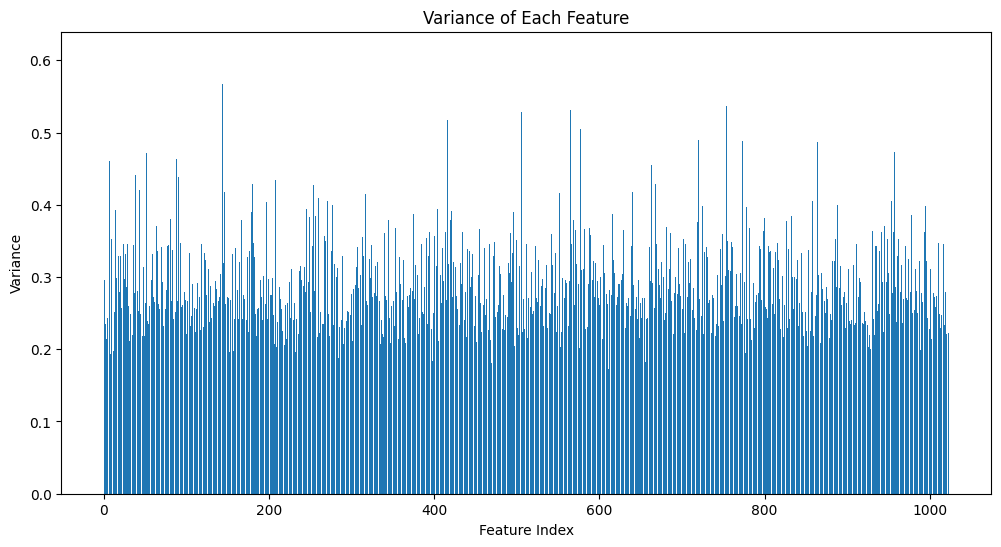

After PCA dimensions (198982, 467)


In [14]:
# Calculate the variance of each feature
feature_variances = X_full.var(axis=0)

# Plot the variances
plt.figure(figsize=(12, 6))
plt.bar(range(feature_variances.shape[0]), feature_variances)
plt.xlabel("Feature Index")
plt.ylabel("Variance")
plt.title("Variance of Each Feature")
plt.show()

pca = PCA(n_components=.95)

# Fit PCA on the dataset (calculates principal components)
pca.fit(X_full)
X_reduced = np.float32(pca.transform(X_full))
print ("After PCA dimensions", X_reduced.shape)

All the features have a significant variance. We cant filter out any feature with low variance...But PCA is performed to reduce the dimension of the data

In [15]:

joblib.dump(mlb, 'mlb.pkl')  # Save MultiLabelBinarizer
joblib.dump(mlb_new, 'mlb_new.pkl')  # Save MultiLabelBinarizer
joblib.dump(pca, "pca.pkl")

['pca.pkl']

# Sampling

To manage the large dataset effectively and reduce computational overhead during experimentation, a sampling technique was implemented. A random subset of 10% of the data was selected for training and testing initial model configurations.

In [24]:
random_state = 34
np.random.seed(random_state)
# Choose random indices, selecting 10% of the data without replacement
chosen_idx = np.random.choice(X_full.shape[0], replace=False, size=int(X_full.shape[0] ))
# Sample the data using the chosen indices
X_sampled = X_reduced[chosen_idx]
y_sampled = y[chosen_idx]

_, X_test, _, y_test = train_test_split(X_full, y, test_size=0.05)

print("Dimensions of X:", X_sampled.shape, "Dimensions of y:", y_sampled.shape)

Dimensions of X: (198982, 467) Dimensions of y: (198982, 390)


# Models

**Model 1 : Logistic Regression**

To predict the ICD10 codes, a Logistic Regression model was implemented as a multi-output classifier due to the multi-label nature of the problem.

MultiOutputClassifier with Logistic Regression: Logistic Regression was chosen as a baseline model for its interpretability and efficiency in handling high-dimensional data. The MultiOutputClassifier wrapper allowed the model to predict multiple labels for each data point independently.
Hyperparameter Tuning:

The regularization parameter, C, was tuned by evaluating various values from [10e-4, 10]. This hyperparameter controls the regularization strength, balancing model complexity and accuracy. Finally, c=10 gave the best results.
Each model configuration was trained and evaluated on the sampled dataset (X_sampled, y_sampled) to select the best-performing parameter based on the micro-averaged F-beta (F2) score.


Micro F-beta Score: Since micro-averaged F2 is the evaluation metric, the fbeta_score function with beta=2 was used to compute this on the predictions for each C value. The best-performing model was saved for future evaluation.

With C=10 yielding the highest F2 score on the sampled dataset, the final model was trained on the entire sample set using this configuration. The model was then saved using joblib.dump for further usage or potential retraining on the full dataset.


In [23]:
# Hyperparameter tuning 
for c in [5,10] :
    clf = MultiOutputClassifier(LogisticRegression(C=c))
    clf.fit(np.float16(X_sampled), y_sampled)
    print ("F.BETA Score: for c",c, fbeta_score(clf.predict(X_sampled), y_sampled, beta=2, average='micro'))


F.BETA Score: for c 5 0.9629183388909158
F.BETA Score: for c 10 0.9645189039782263


In [25]:

clf = MultiOutputClassifier(LogisticRegression(C=10))
clf.fit(np.float16(X_sampled), y_sampled)
joblib.dump(clf, 'LR_19.pkl')  # Save model parameters

print ("F.BETA Score:", fbeta_score(clf.predict(X_sampled), y_sampled, beta=2, average='micro'))



F.BETA Score: 0.9012952358073408


Training accuracy of 0.90 was achieved.......but leaderboard accuracy never crossed 0.3 :(

**Model 2: Neural Networks**

A neural network was constructed on full dataset without any pca reduction or label filtering.

Neural Network Architecture
The model architecture was designed to handle high-dimensional embeddings and produce multi-label outputs. Each component of the architecture is detailed below:

Input Layer:

Dense Layer with 1024 Units: The input layer is a fully connected (Dense) layer with 1024 neurons, each activated by a ReLU function. The high number of neurons enables the model to learn a rich representation of the embedding space, capturing complex patterns across a large number of input features.

Hidden Layers:

Layer 1: The first hidden layer contains 1200 neurons with ReLU activation. By expanding the layer size, the model is equipped to learn diverse, intermediate representations between the input embeddings and the final output. This layer is followed by Batch Normalization, which normalizes the output to maintain stable gradients and improve convergence speed, and Dropout (0.3), which randomly drops 30% of neurons during each training step to reduce over fitting.

Layer 2: The second hidden layer has 1400 neurons and also uses ReLU activation, Batch Normalization, and Dropout (0.3). This layer, with an even larger number of neurons, allows the network to capture subtle non-linear relationships that might be relevant to correctly classifying a broader range of ICD10 codes.

Layer 3: A final dense layer (or the last hidden layer) with 1400 neurons serves as a bridge between the deep feature representations from the hidden layers and the output layer. It also includes Batch Normalization and Dropout (0.3) to enhance regularization and prevent overfitting.

Output Layer:

The output layer has units equal to the number of ICD10 classes, with sigmoid activation. Using a sigmoid activation function for each output unit provides a probability score between 0 and 1, allowing the model to handle multi-label classification by treating each ICD10 code as an independent binary classification problem.


In [6]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import fbeta_score
import pandas as pd

# Set the random state for reproducibility
random_state = 34
np.random.seed(random_state)

# Choose random indices, selecting 10% of the data without replacement
chosen_idx = np.random.choice(X_full.shape[0], replace=False, size=int(X_full.shape[0]))
X_train = X_full[chosen_idx]
y_train = y_full_binary[chosen_idx]

print(X_train.shape, y_train.shape)




(198982, 1024) (198982, 1400)


c:\Users\hiran\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 153s 49ms/step - loss: 0.0802 - val_loss: 0.0022
Epoch 2/15
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 214s 53ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 3/15
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 199s 52ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 4/15
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 147s 48ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 5/15
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 98s 32ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/15
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 101s 33ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 7/15
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 99s 32ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 8/15
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 99s 32ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 9/15
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 100s 32ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 10/15
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 99s 32ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 11/15
3078/3078 ━━━━━━━━━━━━━━━━━━━━ 99s 32ms/step - loss: 0.0013 - val_loss: 0.0015
Ep

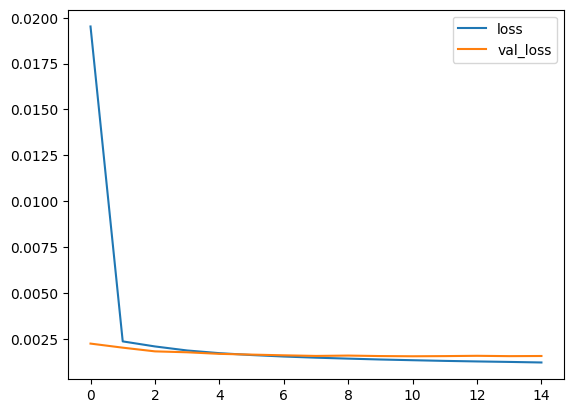

In [16]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    Dense(1024, activation='relu', input_dim=input_dim),
    BatchNormalization(),
    Dropout(0.3), # Normalize outputs of the first dense layer
    
    Dense(1200, activation='relu'),
    BatchNormalization(), 
    Dropout(0.3),   
    
    Dense(1400, activation='relu'),
    BatchNormalization(), 
    Dropout(0.3), 

    Dense(output_dim, activation='sigmoid')  # Sigmoid for multilabel outputs
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')

# Add EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor the validation loss
    patience=20,           # Stop training if val_loss doesn't improve for 5 epochs
    restore_best_weights=True  # Restore model weights from the epoch with the best val_loss
)

# Train the model with early stopping
losses = model.fit(
    np.float16(X_train), y_train,validation_split=0.01,
    batch_size=int(64),
    epochs=15,  # Total epochs (early stopping may stop earlier)
    callbacks=[early_stopping]  # Add early stopping callback
)

model.save("NN_25.keras")
# Plot training and validation loss
loss_df = pd.DataFrame(losses.history)
loss_df[['loss', 'val_loss']].plot()

# Predict and evaluate model
y_pred_prob = model.predict(X_train)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate F-beta score
print("F.BETA Score: ", fbeta_score(y_train, y_pred, beta=2, average='micro'))

This model had the best leaderboard output with a micro-F2 score of 0.461. The following code is run to output the final submission file


In [17]:
# prediction

# Load the data
X_final = np.load(r"C:\Users\hiran\Desktop\SEM7\DAL\Final_Challenge\test_data.npy")
print("Loaded Data...", X_final.shape)


# Load the trained model and make predictions
# model = joblib.load(r"C:\Users\hiran\Desktop\SEM7\DAL\Final_Challenge\NN_03.pkl")
y_binary = model.predict(X_final)
y_binary = (y_binary > 0.5).astype(int)

print("Predictions done...Working on final conversion")

# Load the MultiLabelBinarizer and use inverse_transform

y_pred = mlb.inverse_transform(y_binary)  # Changed 'inverse' to 'inverse_transform'

print("Writing output file", len(y_pred))

submission_df = pd.DataFrame({
    "id": range(1, len(y_pred) + 1),  # Generates an id column starting from 1
    "labels": [";".join(sorted(labels)) if labels else "" for labels in y_pred]  # Sort and join labels with ';' separator
})

# Save the DataFrame to a CSV file
submission_df.to_csv("submission_NN_25.csv", index=False)



Loaded Data... (99490, 1024)
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Predictions done...Working on final conversion
Writing output file 99490
